In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import os
from run import InputFeatures
from sklearn.cluster import KMeans
from scipy import spatial
import ast
import re

In [2]:
vectorizer = TfidfVectorizer()

In [3]:
with open('C:\ds\senatus-code-s4\dataset\\10_topics_train_dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [4]:
docstrings = []
for repo in list(set(dataset['repo'].tolist())):
        dataset_repo = dataset[dataset['repo'] == repo]
        for file_path in dataset_repo['file'].tolist():
                with open(os.path.join('..', file_path), 'r', encoding="utf-8") as f:
                    file_content = f.read()
                try:
                    tree = ast.parse(file_content)
                except:
                    continue
                docstring = ast.get_docstring(tree)
                if docstring is None:
                    continue
                encoded_string = docstring.encode("ascii", 'ignore')
                docstring = encoded_string.decode()
                docstring = re.sub(r'[^A-Za-z,!?\d\.\"\']+', " ", docstring)
                docstring = re.split(r'[\.]+', docstring)
                docstring = [doc.strip() for doc in docstring if len(doc.split())>3 
                             and any(map(str.isdigit, doc)) is False
                            and doc.strip()[0] == doc.strip()[0].capitalize()]
                docstrings.extend(docstring)

In [5]:
docstrings

['A deep MNIST classifier using convolutional layers',
 'See the paper "Inverted Residuals and Linear Bottlenecks Mobile Networks for Classification, Detection and Segmentation" for more details',
 'NNI exmaple for fine tuning the pruned model with KD',
 'Run basic pruners torch',
 'Then pass the mask as argument for model speedup',
 'The compressed model is further used for fine tuning',
 'A deep MNIST classifier using convolutional layers',
 'This file is a modification of the official pytorch mnist example https github',
 'Train the network combined by RNN and attention',
 'Script for installation and distribution',
 'You can use environment variable NNI RELEASE to set release version',
 'Development Build and install for development python setup',
 'Reference We use tested models from https github',
 'A deep MNIST classifier using convolutional layers',
 'This file is a modification of the official pytorch mnist example https github',
 'Module implementing base classes for common n

In [6]:
vectorized_docstring = vectorizer.fit_transform(docstrings)

In [7]:
clustering_model = KMeans(n_clusters=3,
                         max_iter=1000)

In [8]:
labels = clustering_model.fit_predict(vectorized_docstring)

In [9]:
## Study of label 2 samples:
samples_2 = []
for i, label in enumerate(labels):
    if label == 0:
        samples_2.append(docstrings[i])

In [10]:
samples_2

['You may obtain a copy of the License at http www',
 'See the License for the specific language governing permissions and limitations under the License',
 'You may obtain a copy of the License at http www',
 'See the License for the specific language governing permissions and limitations under the License',
 'See the GNU General Public License for more details',
 'You should have received a copy of the GNU General Public License along with this program',
 'If not, see http www',
 'See the GNU General Public License for more details',
 'You should have received a copy of the GNU General Public License along with this program',
 'If not, see http www',
 'See the GNU General Public License for more details',
 'You should have received a copy of the GNU General Public License along with this program',
 'If not, see http www',
 'See the GNU General Public License for more details',
 'You should have received a copy of the GNU General Public License along with this program',
 'If not, see h

In [11]:
with open('C:\ds\senatus-code-s4\dataset\\10_topics_test_dataset.pkl', 'rb') as f:
    dataset_test = pickle.load(f)

In [12]:
test_docstrings = []
for repo in list(set(dataset_test['repo'].tolist())):
        dataset_repo = dataset_test[dataset_test['repo'] == repo]
        for file_path in dataset_repo['file'].tolist():
                with open(os.path.join('..', file_path), 'r', encoding="utf-8") as f:
                    file_content = f.read()
                try:
                    tree = ast.parse(file_content)
                except:
                    continue
                docstring = ast.get_docstring(tree)
                if docstring is None:
                    continue
                encoded_string = docstring.encode("ascii", 'ignore')
                docstring = encoded_string.decode()
                docstring = re.sub(r'[^A-Za-z,!?\d\.\"\']+', " ", docstring)
                docstring = re.split(r'[\.]+', docstring)
                docstring = [doc.strip() for doc in docstring if len(doc.split())>3 
                             and any(map(str.isdigit, doc)) is False
                            and doc.strip()[0] == doc.strip()[0].capitalize()]
                test_docstrings.extend(docstring)

In [13]:
vectorized_test = vectorizer.transform(test_docstrings)
labels_test = clustering_model.predict(vectorized_test)

In [19]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained('..\distilbert-base-uncased')
model = AutoModel.from_pretrained('..\distilbert-base-uncased')

Some weights of the model checkpoint at ..\distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
import pandas as pd

df = pd.DataFrame(columns=['data', 'label'])
tokenized = [tokenizer(text, return_tensors='pt', padding=True, truncation=True) for text in test_docstrings]
embeded_docstrings = [model(**tok)[0][0][0].detach().numpy() for tok in tokenized]
df['data'] = embeded_docstrings
df['label'] = labels_test

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [34]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=3)
pca_result = pca.fit_transform(np.stack(df['data']))

print(f'Explained variation per principal component: {pca.explained_variance_ratio_}')

Explained variation per principal component: [0.2039165  0.10428932 0.0871119 ]


In [35]:
df['pca-one'] = pca_result[:, 0]
df['pca-two'] = pca_result[:, 1]
df['pca-three'] = pca_result[:, 2]

Text(0.5, 0, 'PCA 1')

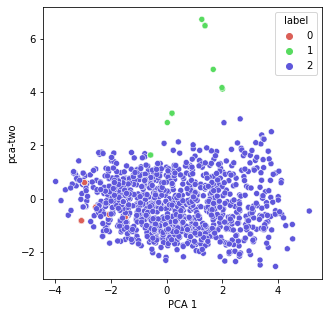

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
## 2D PCA Visualisation

plt.figure(figsize=(5, 5))
fig = sns.scatterplot(x="pca-one", y="pca-two", hue='label',
                palette=sns.color_palette("hls", 3),
               data=df,
               alpha=1)
fig.set_xlabel("PCA 1")

In [40]:
colors = ['red', 'yellow', 'blue', 'orange', 'green']
markers = ['^', '*', '+', 'o', 'd']

<ipython-input-43-62ab0492ed61>:1: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.figure(figsize=(5, 5)).gca(projection='3d')


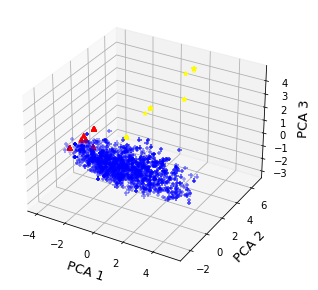

In [43]:
ax = plt.figure(figsize=(5, 5)).gca(projection='3d')
for i, label in enumerate(list(set(df['label'].values))):
    fig = ax.scatter(
    xs=df[df['label']==label]['pca-one'],
    ys=df[df['label']==label]['pca-two'],
    zs=df[df['label']==label]['pca-three'],
    label=df[df['label']==label]['label'].values,
    #c=df[df['labels']==label]['labels'].values,
    marker=markers[i],
    color=colors[i])
ax.set_xlabel('PCA 1', fontsize=13)
ax.set_ylabel('PCA 2', fontsize=13)
ax.set_zlabel('PCA 3', fontsize=13)
ax.tick_params(labelsize=10)

In [44]:
import time

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
tsne_results =tsne.fit_transform(np.stack(df['data'].values))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1267 samples in 0.002s...
[t-SNE] Computed neighbors for 1267 samples in 0.146s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1267
[t-SNE] Computed conditional probabilities for sample 1267 / 1267
[t-SNE] Mean sigma: 1.331485
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.394386
[t-SNE] KL divergence after 300 iterations: 1.364763


In [45]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] =tsne_results[:, 1]

(array([-20., -15., -10.,  -5.,   0.,   5.,  10.,  15.,  20.,  25.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

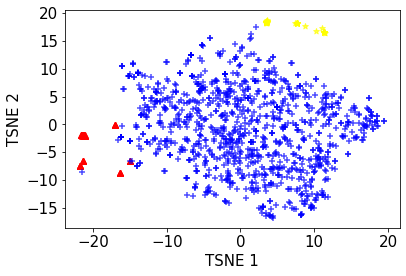

In [48]:
#ax = plt.figure(figsize=(5,5))
"""sns.scatterplot(x="tsne-2d-one", y='tsne-2d-two', hue='labels',
                palette=sns.color_palette("hls", 5),
               data=df,
               alpha=1)"""

for i, label in enumerate(list(set(df['label'].values))):
    fig = plt.scatter(
    df[df['label'] == label]["tsne-2d-one"],
    df[df['label'] == label]["tsne-2d-two"],
    #c=df[df['labels']==label]['labels'].values,
    marker=markers[i],
    color=colors[i],
    alpha=0.7)
plt.xlabel('TSNE 1', fontsize=15)
plt.ylabel('TSNE 2', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [49]:
import subprocess

subprocess.run('git config --global http.proxy http://proxy.jpmchase.net:10443')
subprocess.run('git clone https://huggingface.co/microsoft/codebert-base', capture_output=True, shell=True, check=True)
subprocess.run('git config --global --unset-all http.proxy')

CompletedProcess(args='git config --global --unset-all http.proxy', returncode=0)

In [61]:
import torch

encoder_layer = torch.nn.TransformerEncoderLayer(d_model=768, nhead=8)
transformer_encoder = torch.nn.TransformerEncoder(encoder_layer, num_layers=6)

In [71]:
test_sentence = ['this is a sentence test for testing the shape of the model', "there are many files in this repository", "so we have to mimic that"]
tokenized = tokenizer(test_sentence, return_tensors='pt', padding=True, truncation=True)
result = model(**tokenized)[0].unsqueeze(0)

In [72]:
result.shape

torch.Size([1, 3, 14, 768])

In [73]:
transformer_encoder(result).shape

ValueError: too many values to unpack (expected 3)